In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from diffSPH.v2.modules.viscosity import computeViscosityParameter, setViscosityParameters
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime
from diffSPH.v2.util import computeStatistics
import tomli

In [2]:
configurationFile = './configurations/02_outlet.toml'

with open(configurationFile, 'r') as f:
    config = f.read()

config = tomli.loads(config)

In [3]:
config['domain']

{'adjustParticle': False, 'adjustDomain': False, 'dim': 2, 'periodic': True}

In [4]:
nx = 128
L = 1
u_mag = 2
k = 1 * np.pi
TGV_override = False
targetRe = 2000

config['domain']['minExtent'] = [-2,-2]
config['domain']['maxExtent'] =  [2,2]
config['domain']['periodic'] = False

config['particle'] = {'nx' : nx}
config['fluid'] = {'cs' : u_mag * 10}
config['compute'] = {'device': 'cpu'}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)
setViscosityParameters(config, targetRe, L, u_mag)

print(rf'Re = {config["diffusion"]["Re"]}, $\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$, $\alpha = {config["diffusion"]["alpha"]}$')


$\alpha = 0.005396952852606773$ is very low, consider increasing the value (should be > 0.01)
Re = 1999.9998779296875, $\nu_{sph} = 0.0020000000949949026$, $\alpha = 0.005396952852606773$


In [5]:
config['domain']

{'adjustParticle': False,
 'adjustDomain': False,
 'dim': 2,
 'periodic': False,
 'minExtent': tensor([-2., -2.]),
 'maxExtent': tensor([2., 2.]),
 'periodicity': tensor([False, False])}

In [6]:
# from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict

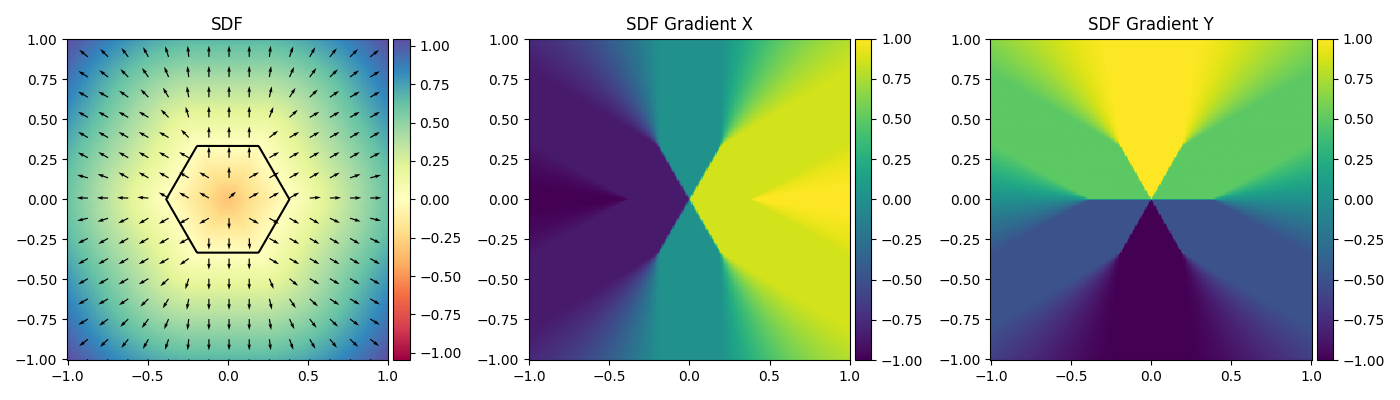

In [7]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict

ngrid = 255
x = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
y = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('hexagon')['function'](points, 1/3)
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/3,1/3]).to(points.device))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)
sdf = operatorDict['smooth_union'](rotated, sphere_a, 0.25)

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)
sdf = sphere_a
plotSDF(sdf(torch.clone(points.to('cuda')),), X.to('cuda'), Y.to('cuda'), 2, 2)

In [8]:
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict
from diffSPH.v2.sampling import find_contour
# from diffSPH.v2.modules.divergence import computeDivergence

# def find_contour(f, minExtent, maxExtent, nGrid, level = 0):
#     contours = measure.find_contours(f.numpy(), level)
#     for ic in range(len(contours)):
#         contours[ic][:,0] = (contours[ic][:,0]) / (f.shape[0] - 1) * (maxExtent[0] - minExtent[0]).numpy() + minExtent[0].numpy()
#         contours[ic][:,1] = (contours[ic][:,1]) / (f.shape[0] - 1) * (maxExtent[1] - minExtent[1]).numpy() + minExtent[1].numpy()
#     return contours

In [52]:
ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1/2]).to(points.device))
inletSDF = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1]).to(points.device))
outletSDF = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/4,1.5]).to(points.device))
outletRegion = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/4,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)


regions = [{
        'sdf': inletSDF,
        'type': 'inlet',
        'velocity': torch.tensor([1,0.]),
        'particles': sampleParticles(config, sdfs = [inletSDF])[0],
        'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    },
    {
        'sdf': inletSDF,
        'type': 'forcing',
        'velocity': torch.tensor([1,0.]),
        'particles': sampleParticles(config, sdfs = [inletSDF])[0],
        'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    },{
        'sdf': outletSDF,
        'type': 'outlet',
        'velocity': torch.tensor([0.,0.]),
        'particles': sampleParticles(config, sdfs = [outletSDF])[0],
        'contour': find_contour(outletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    },{
        'sdf': outletRegion,
        'type': 'mirror',
        'velocity': torch.tensor([0.,0.]),
        'particles': sampleParticles(config, sdfs = [outletRegion])[0],
        'contour': find_contour(outletRegion(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    }
    ]

tensor(-0.1240)


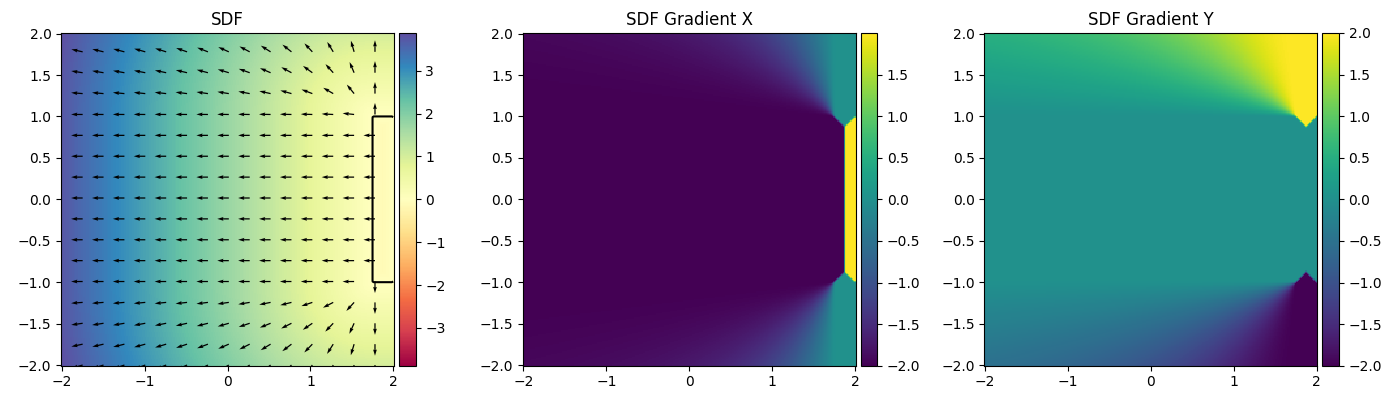

In [53]:


# sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/2,1]).to(points.device))
# outletSDF = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

print(outletSDF(torch.clone(points)).min())
plotSDF(outletSDF(torch.clone(points),), X, Y, 2, 2)

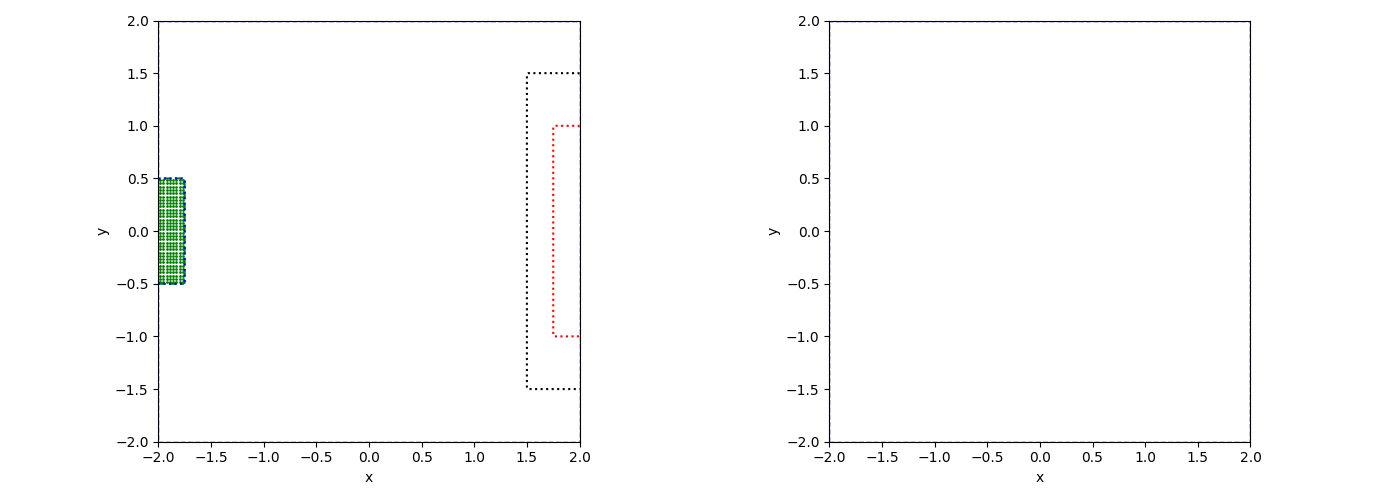

In [71]:
from diffSPH.v2.plotting import setPlotBaseAttributes

fig, axis = plt.subplots(1, 2, figsize = (14,5), squeeze = False)

setPlotBaseAttributes(axis[0,0], config)
setPlotBaseAttributes(axis[0,1], config)

def plotRegions(regions, axis):
    for region in regions:
        # visualizeParticles(region['particles'], axis[0,0], config)
        for ic, contour in enumerate(region['contour']):
            color = 'black'
            style = '-'
            if region['type'] == 'inlet':
                color = 'green'
                style = '--'
            if region['type'] == 'forcing':
                color = 'blue'
                style = ':'
            if region['type'] == 'outlet':
                color = 'red'
                style = ':'
            if region['type'] == 'mirror':
                color = 'black'
                style = ':'
            # axis[0,0].plot(contour[:,0], contour[:,1], color=color)
            axis.plot(contour[:,0], contour[:,1], color = color, ls = style, label = region['type'] if ic == 0 else None)
        if region['type'] == 'inlet':
            axis.scatter(region['particles']['positions'][:,0].detach().cpu().numpy(), region['particles']['positions'][:,1].detach().cpu().numpy(), color = 'green', s = 1)
    # axis[0,0].legend()

plotRegions(regions, axis[0,0])
fig.tight_layout()

    # axis[0,0].contour(X.numpy(), Y.numpy(), fx.numpy(), levels=[0], colors='black')

In [55]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict
from diffSPH.v2.plotting import computePSD, plotFFT, plotPSD, mapToGrid, visualizeParticleQuantity

# particleState, mask = sampleParticles(config, sdfs = [sdf])

In [200]:
# particleState, mask = sampleParticles(config, sdfs = [region['sdf'] for region in regions if region['type'] == 'inlet'])
particleState, mask = sampleParticles(config, sdfs = [sdf])

In [201]:

s = 2
perennialState = {
    'fluid': copy.deepcopy(particleState),
    'time': 0.0,
    'timestep': 0,
    'dt': config['timestep']['dt'],
    'uidCounter': particleState['numParticles']
}

u = 1
perennialState['fluid']['velocities'][:,0] = u

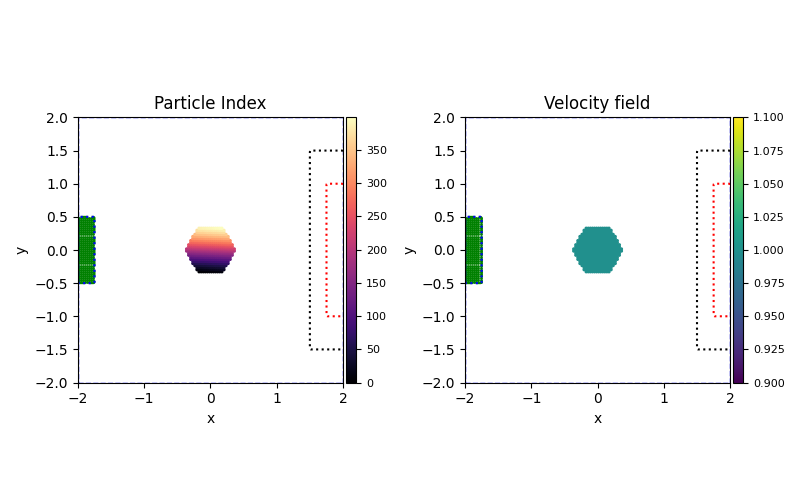

In [202]:
fig, axis = plt.subplots(1,2, figsize = (8,5), squeeze = False)


visualizationState = prepVisualizationState(perennialState, config, grid = True)
plotRegions(regions, axis[0,0])
plotRegions(regions, axis[0,1])

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity = 'index', mapping = '.x', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'magma', title = 'Particle Index')
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 'velocities', mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'viridis', streamLines = False, operation = None, title = 'Velocity field')

fig.tight_layout()

In [203]:
printState(perennialState)

state[fluid                   ]: dict
state[fluid                   ][numParticles      ]: 400	[<class 'int'>]
state[fluid                   ][positions         ]: min: -3.594e-01, max: +3.594e-01, median: -1.562e-02 [torch.Size([400, 2])	@ cpu	x torch.float32	]
state[fluid                   ][areas             ]: min: +9.766e-04, max: +9.766e-04, median: +9.766e-04 [torch.Size([400])	@ cpu	x torch.float32	]
state[fluid                   ][pressures         ]: min: +0.000e+00, max: +0.000e+00, median: +0.000e+00 [torch.Size([400])	@ cpu	x torch.float32	]
state[fluid                   ][divergence        ]: min: +0.000e+00, max: +0.000e+00, median: +0.000e+00 [torch.Size([400])	@ cpu	x torch.float32	]
state[fluid                   ][masses            ]: min: +9.766e-01, max: +9.766e-01, median: +9.766e-01 [torch.Size([400])	@ cpu	x torch.float32	]
state[fluid                   ][supports          ]: min: +1.186e-01, max: +1.186e-01, median: +1.186e-01 [torch.Size([400])	@ cpu	x torch.fl

In [204]:
from diffSPH.v2.plotting import setPlotBaseAttributes

# fig, axis = plt.subplots(1, 2, figsize = (14,5), squeeze = False)

# setPlotBaseAttributes(axis[0,0], config)
# setPlotBaseAttributes(axis[0,1], config)


def processOutlet(region, config, perennialState):
    outletSDF = region['sdf']
    dist = outletSDF(perennialState['fluid']['positions'])
    mask = dist < 0
    reducedIndices = torch.arange(perennialState['fluid']['positions'].shape[0], device = perennialState['fluid']['positions'].device, dtype =  torch.int64)[~mask]

    if mask.sum() == 0:
        return
    print(f'Outlet: {mask.sum()} particles removed')
    print('Current particles:', perennialState['fluid']['positions'].shape[0])
    print(reducedIndices.shape, reducedIndices)

    for k in perennialState['fluid'].keys():
        if isinstance(perennialState['fluid'][k], torch.Tensor):
            perennialState['fluid'][k] = perennialState['fluid'][k][reducedIndices]
    
    perennialState['fluid']['numParticles'] = perennialState['fluid']['positions'].shape[0]

processOutlet(regions[2], config, perennialState)

# sc = axis[0,0].scatter(perennialState['fluid']['positions'][:,0].detach().cpu().numpy(), perennialState['fluid']['positions'][:,1].detach().cpu().numpy(), s = 1, c = mask)
# fig.colorbar(sc, ax = axis[0,0])

In [205]:
# perennialState['fluid']['numParticles'] = perennialState['fluid']['positions'].shape[0]

In [206]:

# # visualizationState = prepVisualizationState(perennialState, config)
# updatePlot(indexPlot, visualizationState, 'index')
# updatePlot(quantPlot, visualizationState, 'velocities')

In [207]:
printState(perennialState)

state[fluid                   ]: dict
state[fluid                   ][numParticles      ]: 400	[<class 'int'>]
state[fluid                   ][positions         ]: min: -3.594e-01, max: +3.594e-01, median: -1.562e-02 [torch.Size([400, 2])	@ cpu	x torch.float32	]
state[fluid                   ][areas             ]: min: +9.766e-04, max: +9.766e-04, median: +9.766e-04 [torch.Size([400])	@ cpu	x torch.float32	]
state[fluid                   ][pressures         ]: min: +0.000e+00, max: +0.000e+00, median: +0.000e+00 [torch.Size([400])	@ cpu	x torch.float32	]
state[fluid                   ][divergence        ]: min: +0.000e+00, max: +0.000e+00, median: +0.000e+00 [torch.Size([400])	@ cpu	x torch.float32	]
state[fluid                   ][masses            ]: min: +9.766e-01, max: +9.766e-01, median: +9.766e-01 [torch.Size([400])	@ cpu	x torch.float32	]
state[fluid                   ][supports          ]: min: +1.186e-01, max: +1.186e-01, median: +1.186e-01 [torch.Size([400])	@ cpu	x torch.fl

In [208]:
def mergeStates(oldState, newState):
    for key in oldState.keys():
        if not isinstance(oldState[key], torch.Tensor):
            continue
        if key in newState.keys():
            # print(f'Merging key {key} with shape {oldState[key].shape} and {newState[key].shape}')
            oldState[key] = torch.cat([oldState[key], newState[key]], dim = 0)
        else:
            # print(f'Key {key} not found in newState')

            pseudoVar = torch.zeros([newState['numParticles'], *oldState[key].shape[1:]], dtype = oldState[key].dtype, device = oldState[key].device)
            # print(pseudoVar.shape)

            oldState[key] = torch.cat([oldState[key], pseudoVar], dim = 0)
    oldState['numParticles'] = oldState['positions'].shape[0]#.detach().cpu().item()
    return oldState


# print(emitterPositions['numParticles'], newPositions.shape[0])


In [209]:
torch.zeros([100, *perennialState['fluid']['positions'].shape[1:]])

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

In [210]:
def processInlet(perennialState, emitter):
    emitterState = emitter['particles']

    emitterNeighborhood = neighborSearch(emitterState, perennialState['fluid'], config, computeKernels=False)

    distance = emitterNeighborhood['distances']
    i = emitterNeighborhood['indices'][0]
    newDistance = distance.new_ones(emitterState['numParticles'], dtype = config['compute']['dtype']) #* config['particle']['support']
    minDistance = newDistance.index_reduce_(dim = 0, index = i, source = distance, include_self = False, reduce = 'amin')

    emitterMask = minDistance >= config['particle']['dx'] / config['particle']['support']

    newPositions = emitterState['positions'][emitterMask].to(config['compute']['device'])
    newParticleState = {
        'numParticles': newPositions.shape[0],#.detach().cpu(),
        'positions': newPositions,

        'areas': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['particle']['volume'],
        'masses': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['particle']['volume'] * config['fluid']['rho0'],
        'densities': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['fluid']['rho0'],
        'supports': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['particle']['support'],

        'pressures': torch.zeros(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']),
        'divergence': torch.zeros(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']),

        'velocities': torch.zeros(newPositions.shape, dtype = config['compute']['dtype'], device = config['compute']['device']),
        'accelerations': torch.zeros(newPositions.shape, dtype = config['compute']['dtype'], device = config['compute']['device']),
        'index': torch.arange(newPositions.shape[0], dtype = torch.int32, device = config['compute']['device']) + perennialState['uidCounter'],
        # 'neighbors': None,
    }
    newParticleState['velocities'][:,0] = emitter['velocity'][0]
    newParticleState['velocities'][:,1] = emitter['velocity'][1]
    
    # print(f'Adding {newParticleState["numParticles"]} particles (total {perennialState["fluid"]["numParticles"] + newParticleState["numParticles"]})')
    perennialState['uidCounter'] += newParticleState['numParticles']

    perennialState['fluid'] = mergeStates(perennialState['fluid'], newParticleState)

In [212]:

for i in tqdm(range(1500)):
    # perennialState = simulationStep(perennialState, config)
    perennialState['time'] += config['timestep']['dt']
    perennialState['fluid']['positions'] += perennialState['fluid']['velocities'] * config['timestep']['dt']

    if i % 50 == 0:
        # printState(perennialState)
        # print(f'Iteration {i}')
        visualizationState = prepVisualizationState(perennialState, config)
        updatePlot(indexPlot, visualizationState, 'index')
        updatePlot(quantPlot, visualizationState, 'velocities')
        fig.canvas.draw()
        fig.canvas.flush_events()

    for emitter in regions:
        if emitter['type'] == 'inlet':
            processInlet(perennialState, emitter)
        if emitter['type'] == 'outlet':
            processOutlet(emitter, config, perennialState)

    # emitterNeighborhood = neighborSearch(emitterPositions, perennialState['fluid'], config, computeKernels=False)

    # distance = emitterNeighborhood['distances']
    # i = emitterNeighborhood['indices'][0]
    # newDistance = distance.new_ones(emitterPositions['numParticles'], dtype = config['compute']['dtype']) #* config['particle']['support']
    # minDistance = newDistance.index_reduce_(dim = 0, index = i, source = distance, include_self = False, reduce = 'amin')

    # emitterMask = minDistance >= config['particle']['dx'] / config['particle']['support']

    # newPositions = emitterPositions['positions'][emitterMask].to(config['compute']['device'])
    # newParticleState = {
    #     'numParticles': newPositions.shape[0],
    #     'positions': newPositions,

    #     'areas': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['particle']['volume'],
    #     'masses': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['particle']['volume'] * config['fluid']['rho0'],
    #     'densities': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['fluid']['rho0'],
    #     'supports': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['particle']['support'],

    #     'pressures': torch.zeros(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']),
    #     'divergence': torch.zeros(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']),

    #     'velocities': torch.zeros(newPositions.shape, dtype = config['compute']['dtype'], device = config['compute']['device']),
    #     'accelerations': torch.zeros(newPositions.shape, dtype = config['compute']['dtype'], device = config['compute']['device']),
    #     'index': torch.arange(newPositions.shape[0], dtype = torch.int32, device = config['compute']['device']) + perennialState['uidCounter'],
    #     # 'neighbors': None,
    # }
    # newParticleState['velocities'][:,0] = u
    # # print(f'Adding {newParticleState["numParticles"]} particles (total {perennialState["fluid"]["numParticles"] + newParticleState["numParticles"]})')
    # perennialState['uidCounter'] += newParticleState['numParticles']

    # perennialState['fluid'] = mergeStates(perennialState['fluid'], newParticleState)


# visualizationState = prepVisualizationState(perennialState, config)
# updatePlot(indexPlot, visualizationState, 'index')
# updatePlot(quantPlot, visualizationState, 'densities')

  0%|          | 0/1500 [00:00<?, ?it/s]

Outlet: 16 particles removed
Current particles: 2128
torch.Size([2112]) tensor([   0,    1,    2,  ..., 2125, 2126, 2127])
Outlet: 20 particles removed
Current particles: 2144
torch.Size([2124]) tensor([   0,    1,    2,  ..., 2141, 2142, 2143])
Outlet: 22 particles removed
Current particles: 2156
torch.Size([2134]) tensor([   0,    1,    2,  ..., 2153, 2154, 2155])
Outlet: 22 particles removed
Current particles: 2166
torch.Size([2144]) tensor([   0,    1,    2,  ..., 2163, 2164, 2165])
Outlet: 22 particles removed
Current particles: 2176
torch.Size([2154]) tensor([   0,    1,    2,  ..., 2173, 2174, 2175])
Outlet: 22 particles removed
Current particles: 2186
torch.Size([2164]) tensor([   0,    1,    2,  ..., 2183, 2184, 2185])
Outlet: 22 particles removed
Current particles: 2196
torch.Size([2174]) tensor([   0,    1,    2,  ..., 2193, 2194, 2195])
Outlet: 22 particles removed
Current particles: 2206
torch.Size([2184]) tensor([   0,    1,    2,  ..., 2203, 2204, 2205])
Outlet: 22 parti

In [99]:
emitterPositions

{'numParticles': 1560,
 'positions': tensor([[-0.1953, -0.3203],
         [-0.1797, -0.3203],
         [-0.1641, -0.3203],
         ...,
         [ 0.1641,  0.3203],
         [ 0.1797,  0.3203],
         [ 0.1953,  0.3203]], device='cuda:0'),
 'areas': tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002], device='cuda:0'),
 'pressures': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'divergence': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'masses': tensor([0.2441, 0.2441, 0.2441,  ..., 0.2441, 0.2441, 0.2441], device='cuda:0'),
 'supports': tensor([0.0593, 0.0593, 0.0593,  ..., 0.0593, 0.0593, 0.0593], device='cuda:0'),
 'index': tensor([   0,    1,    2,  ..., 1557, 1558, 1559], device='cuda:0'),
 'densities': tensor([1000., 1000., 1000.,  ..., 1000., 1000., 1000.], device='cuda:0'),
 'velocities': tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]], device='cuda:0'),
 'accele

In [100]:
config['particle']

{'nx': 128,
 'dx': tensor(0.0156, device='cuda:0'),
 'support': tensor(0.0593, device='cuda:0'),
 'defaultVolume': tensor(0.0002, device='cuda:0'),
 'defaultSupport': tensor(0.0593, device='cuda:0'),
 'volume': tensor(0.0002, device='cuda:0'),
 'smoothingLength': tensor(0.0312, device='cuda:0')}

1560 1434


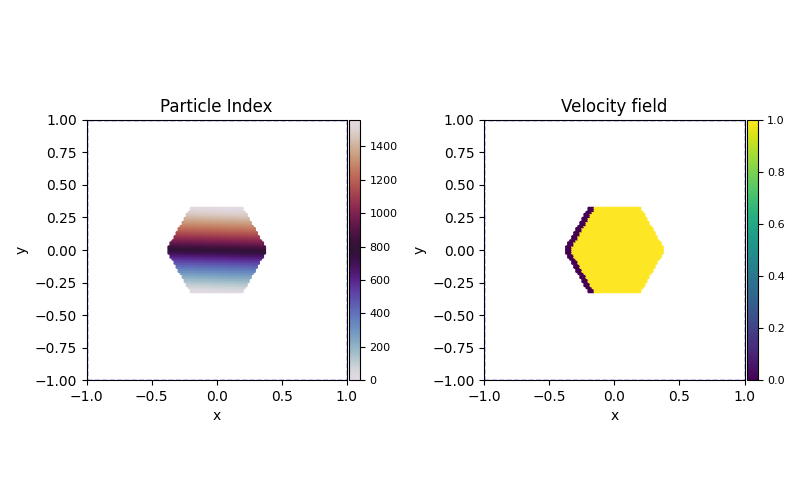

In [102]:
fig, axis = plt.subplots(1,2, figsize = (8,5), squeeze = False)

s = 2
emitterState = {
    'fluid': copy.deepcopy(emitterPositions),
    'time': 0.0,
    'timestep': 0,
    'dt': config['timestep']['dt'],
}

u = 1
perennialState['fluid']['velocities'][:,0] = u

visualizationState = prepVisualizationState(emitterState, config)

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity = 'index', mapping = '.x', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'twilight', title = 'Particle Index')
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = emitterMask, mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'viridis', streamLines = False, operation = None, title = 'Velocity field')

fig.tight_layout()

{'numParticles': 7296,
 'positions': tensor([[-0.1453, -0.3203],
         [-0.1297, -0.3203],
         [-0.1141, -0.3203],
         ...,
         [ 0.1641,  0.3203],
         [ 0.1797,  0.3203],
         [ 0.1953,  0.3203]], device='cuda:0'),
 'areas': tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002], device='cuda:0'),
 'pressures': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'divergence': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'masses': tensor([0.2441, 0.2441, 0.2441,  ..., 0.2441, 0.2441, 0.2441], device='cuda:0'),
 'supports': tensor([0.0593, 0.0593, 0.0593,  ..., 0.0593, 0.0593, 0.0593], device='cuda:0'),
 'index': tensor([   0,    1,    2,  ..., 1431, 1432, 1433], device='cuda:0'),
 'densities': tensor([1000., 1000., 1000.,  ..., 1000., 1000., 1000.], device='cuda:0'),
 'velocities': tensor([[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]], device='cuda:0'),
 'accele

In [70]:
emitterPositions

{'numParticles': 1560,
 'positions': tensor([[-0.1953, -0.3203],
         [-0.1797, -0.3203],
         [-0.1641, -0.3203],
         ...,
         [ 0.1641,  0.3203],
         [ 0.1797,  0.3203],
         [ 0.1953,  0.3203]], device='cuda:0'),
 'areas': tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002], device='cuda:0'),
 'pressures': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'divergence': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'masses': tensor([0.2441, 0.2441, 0.2441,  ..., 0.2441, 0.2441, 0.2441], device='cuda:0'),
 'supports': tensor([0.0593, 0.0593, 0.0593,  ..., 0.0593, 0.0593, 0.0593], device='cuda:0'),
 'index': tensor([   0,    1,    2,  ..., 1557, 1558, 1559], device='cuda:0'),
 'densities': tensor([1000., 1000., 1000.,  ..., 1000., 1000., 1000.], device='cuda:0'),
 'velocities': tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]], device='cuda:0'),
 'accele

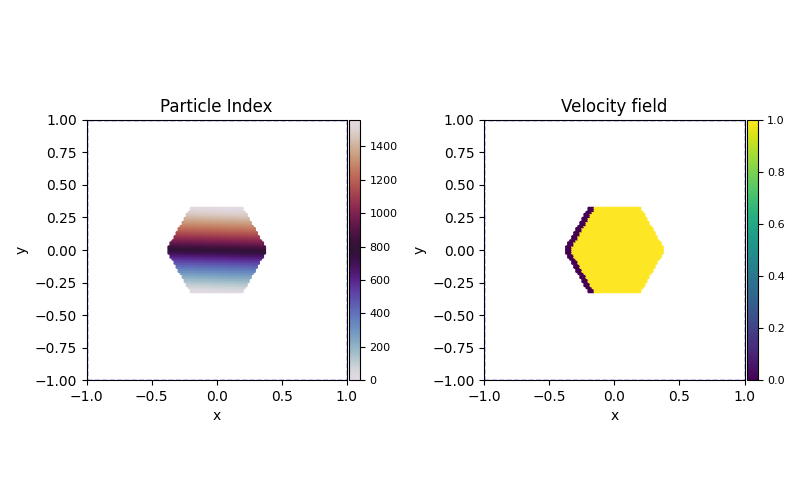

In [17]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict

particleState, mask = sampleParticles(config, sdfs = [sdf])

priorState = None
# particleState['velocities'][:,0] =  u_mag * torch.cos(k * particleState['positions'][:,0]) * torch.sin(k * particleState['positions'][:,1])
# particleState['velocities'][:,1] = -u_mag * torch.sin(k * particleState['positions'][:,0]) * torch.cos(k * particleState['positions'][:,1])
particleState['velocities'][:,0] =  1 
particleState['velocities'][:,1] = 0

u_max = torch.linalg.norm(particleState['velocities'], dim = 1).max()
# particleState['velocities'] = particleState['velocities'] / (u_max + 1e-7) * u_mag
Ek0 = 0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(particleState['velocities'], dim = -1)**2

initialVelocities = particleState['velocities'].clone()

particleState['Eks'] =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2)
particleState['E_k'] = particleState['Eks'].sum().cpu().detach().item()

# perennialState = {
#     'fluid': copy.deepcopy(particleState),
#     'time': 0.0,
#     'timestep': 0,
#     'dt': config['timestep']['dt'],
# }
# del particleState['neighborhood']


In [18]:
# from diffSPH.v2.plotting import computePSD, plotFFT, plotPSD, mapToGrid, visualizeParticleQuantity

# s = 2

# fig, axis = plt.subplot_mosaic('''AB''', figsize=(10.5,5), sharex = False, sharey = False)

# visualizationState = prepVisualizationState(perennialState, config)

# visualizeParticleQuantity(fig, axis['A'], config, visualizationState, quantity = 'index', mapping = '.x', s = s, 
#                           scaling = 'lin', gridVisualization=False, cmap = 'twilight', title = 'Particle Index')
# visualizeParticleQuantity(fig, axis['B'], config, visualizationState, quantity = 'velocities', mapping = 'L2', s = s, 
#                           scaling = 'sym', gridVisualization=True, cmap = 'icefire', streamLines = True, operation = None, title = 'Velocity field')

# E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()
# E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
# nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
# Re = u_mag * 2 / nu_total

# fig.suptitle(f'Taylor-Green Vortex (TGV), $Re = {targetRe}$, particles = {nx}x{nx} = {nx**2}\n $t = {perennialState["time"]:.2f}$, $\Delta t = {perennialState["dt"]:.3e}$, $k = {k/np.pi}$, $u_0 = {u_mag}$, $L = {L}$, $E_k^0 = {Ek0.sum():.2f}$/$E_k = {particleState["E_k"]:.2f}$ -> Re = {Re}')

# fig.tight_layout()

In [19]:
# torch.cuda.memory._record_memory_history(max_entries=100000)

Setting up initial plot
Computing visualization state
Setting up plot A
Setting up plot B
Done setting up initial plot


0.0000%|          | 0/1 [00:00<?] ?it/s

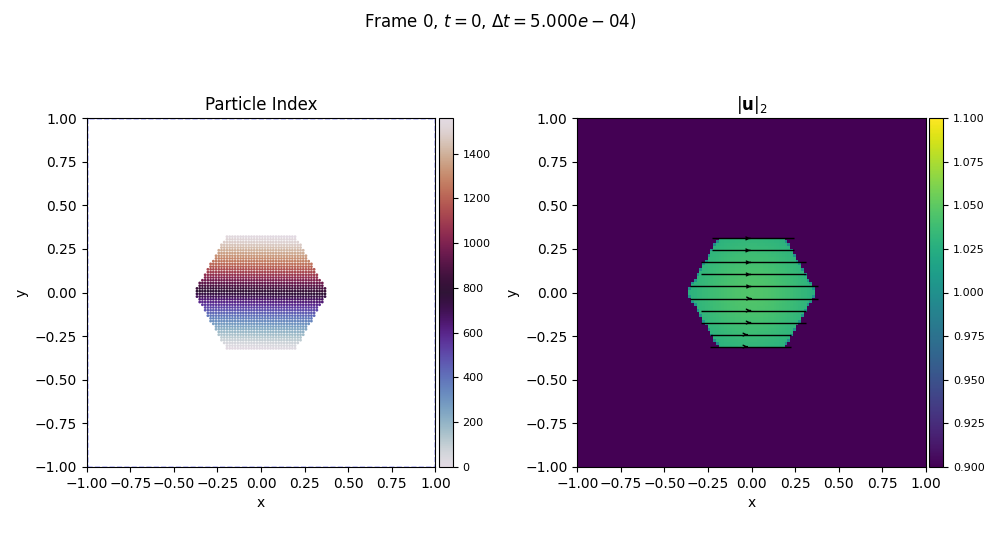

In [20]:
from diffSPH.v2.plotting import updatePlots
from diffSPH.v2.runner import runSimulation, setupSimulation

def callBackFn(perennialState, particleState, config, plotStates, fig, axis, frameStatistics):
    pass
    # E_k = perennialState['fluid']['E_k']
    # nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
    # Re = u_mag * 2 / nu_total
    # title = fig.suptitle(f'Taylor-Green Vortex (TGV), $Re = {targetRe}$, particles = {nx}x{nx} = {nx**2}\n $t = {perennialState["time"]:.2f}$, $\Delta t = {perennialState["dt"]:.3e}$, $k = {k/np.pi}$, $u_0 = {u_mag}$, $L = {L}$, $E_k^0 = {Ek0.sum():.2f}$/$E_k = {particleState["E_k"]:.2f}$ -> Re = {Re}')

config['timestep']['active'] = False
config['timestep']['dt'] = 5e-4
initialState = {
    'fluid': particleState,
    'time': 0.0,
    'timestep': 0,
    'dt': torch.tensor(5e-4, device = config['compute']['device']),
}

perennialState, fig, axis, plotStates, priorState, pbar, stats = setupSimulation(initialState, config, stepLimit = -1, timeLimit = 1)

# E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()
# E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
# nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
# Re = u_mag * 2 / nu_total

# title = fig.suptitle(f'Taylor-Green Vortex (TGV), $Re = {targetRe}$, particles = {nx}x{nx} = {nx**2}\n $t = {perennialState["time"]:.2f}$, $\Delta t = {perennialState["dt"]:.3e}$, $k = {k/np.pi}$, $u_0 = {u_mag}$, $L = {L}$, $E_k^0 = {Ek0.sum():.2f}$/$E_k = {particleState["E_k"]:.2f}$ -> Re = {Re}')
fig.tight_layout()

# updatePlots(perennialState, particleState, config, plotStates, fig, axis)

In [21]:

stat, pstate = runSimulation(fig, axis, simulationStep, plotStates, priorState, pbar, stats, perennialState, particleState, config, stepLimit = -1, timeLimit = 1, callBack = None)
# 

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x795dc6e18b50>>
Traceback (most recent call last):
  File "/home/winchenbach/anaconda3/envs/torch_22/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [12]:
# torch.cuda.memory._dump_snapshot('dump.pth')

In [11]:
config['shifting']

{'scheme': 'deltaSPH',
 'threshold': 0.05,
 'maxIterations': 1,
 'freeSurface': False,
 'R': 0.25,
 'n': 4,
 'CFL': 1.5,
 'computeMach': True,
 'solver': 'BiCGStab_wJacobi',
 'normalScheme': 'lambda',
 'projectionScheme': 'mat',
 'surfaceScaling': 0.1,
 'summationDensity': False,
 'useExtendedMask': False,
 'initialization': 'zero',
 'maxSolveIter': 64,
 'surfaceDetection': 'Barcasco',
 'active': True}

In [12]:

from torch.profiler import profile, record_function, ProfilerActivity

curState = copy.deepcopy(perennialState)
priorState = None



with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:    
    for i in tqdm(range(32)):
        with record_function("timing"): 
            curState, priorState, *updates = integrate(simulationStep, curState, config, previousStep= priorState)
            # Particle shifting
            dx, _ = solveShifting(curState, config)
            curState['fluid']['shiftAmount'] = dx
            curState['fluid']['positions'] += dx

        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))


prof.export_chrome_trace("trace.json")

STAGE:2024-05-22 11:06:28 1367417:1367417 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


  0%|          | 0/32 [00:00<?, ?it/s]

STAGE:2024-05-22 11:06:32 1367417:1367417 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-22 11:06:32 1367417:1367417 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 timing         0.24%       6.717ms       100.00%        2.852s      89.131ms       0.000us         0.00%        1.035s      32.333ms           0 b      -2.00 Mb      13.95 Mb    -138.70 M

In [13]:

print(prof.key_averages().table(sort_by='cuda_time_total'))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 timing         0.24%       6.717ms       100.00%        2.852s      89.131ms       0.000us         0.00%        1.035s      32.333ms           0 b      -2.00 Mb      13.95 Mb    -138.70 M

In [ ]:
def callBackFn(perennialState, particleState, config, plotStates, fig, axis, frameStatistics):
    perennialState['fluid']['E_k']
    nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
    Re = u_mag * 2 / nu_total
    title = fig.suptitle(f'Taylor-Green Vortex (TGV), $Re = {targetRe}$, particles = {nx}x{nx} = {nx**2}\n $t = {perennialState["time"]:.2f}$, $\Delta t = {perennialState["dt"]:.3e}$, $k = {k/np.pi}$, $u_0 = {u_mag}$, $L = {L}$, $E_k^0 = {Ek0.sum():.2f}$/$E_k = {particleState["E_k"]:.2f}$ -> Re = {Re}')

    

def runSimulation(fig, axis, simulationStep, plotStates, priorState, pbar, stats, perennialState, particleState, config, stepLimit = 1000, timeLimit = -1, callBack = None):
    # for i in tqdm(range(1000)):
    frameStatistics = computeStatistics(perennialState, particleState, config)
    stats.append(frameStatistics)
    if perennialState['timestep'] % config['plot']['updateInterval'] == 0:
        updatePlots(perennialState, particleState, config, plotStates, fig, axis)
    if config['export']['active']:
        f, simulationDataGroup = createOutputFile(config)
        
    lastUpdate = perennialState['time']
    while(True):
        perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
        # Particle shifting
        dx, _ = solveShifting(perennialState, config)
        perennialState['fluid']['shiftAmount'] = dx
        perennialState['fluid']['positions'] += dx
        # Frame done, update state for next timestep
        perennialState['dt'] = config['timestep']['dt']
        perennialState['fluid']['Eks'] = (0.5 * perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = -1)**2)
        perennialState['fluid']['E_k'] = perennialState['fluid']['Eks'].sum().detach().cpu().item()
        frameStatistics = computeStatistics(perennialState, particleState, config)
        
        if config['export']['active']:
            if perennialState['timestep'] % config['export']['interval'] == 0:
                writeFrame(simulationDataGroup, perennialState, priorState, frameStatistics, config)

        
        perennialState['time'] += config['timestep']['dt']
        perennialState['timestep'] += 1

        config['timestep']['dt'] = computeTimestep(perennialState, config)
        time = perennialState['time']
        dt = config['timestep']['dt']

        if timeLimit > 0:
            pbar.n = time.detach().cpu().item() if isinstance(time, torch.Tensor) else time
            pbar.refresh()
        else: 
            pbar.n = perennialState['timestep']
            pbar.refresh()
        if perennialState['time'] > timeLimit and timeLimit > 0:
            break
        if perennialState['timestep'] > stepLimit and stepLimit > 0:
            break



        ttime = perennialState['time'] if not isinstance(perennialState['time'], torch.Tensor) else perennialState['time'].cpu().item()
        stats.append(frameStatistics)

        if callBack is not None:
            callBack(perennialState, particleState, config, plotStates, fig, axis, frameStatistics)
        if config['plot']['fps'] > 0:
            if perennialState['time'] > lastUpdate + 1 / config['plot']['fps']:
                lastUpdate = ttime
                updatePlots(perennialState, particleState, config, plotStates, fig, axis)
        else:
            if perennialState['timestep'] % config['plot']['updateInterval'] == 0:
                updatePlots(perennialState, particleState, config, plotStates, fig, axis)

    pbar.close()
    if config['export']['active']:
        f.close()

    postProcessPlot(config)
    return stats, perennialState